In [5]:
import sys
import os

sys.path.append(os.getcwd())
sys.path.append('/mnt/ceph/home/aa1087312/.local/lib/python3.6/site-packages') #only needed on idaas

import numpy as np
import refnx
from refnx.dataset import ReflectDataset
from refnx.analysis import Transform, CurveFitter, Objective, GlobalObjective, Parameter
from refnx.reflect import SLD, ReflectModel, MixedReflectModel, Slab, Structure
import scipy
import periodictable
import matplotlib.pyplot as plt
import dynesty

from VFP import VFP

In [6]:
np.random.seed(42)

### First lets create a simple model.

This is similar to the model used in the Compare SLD and reflectivity notebook.  
We will create the model using `VFP`, then we will simulate the reflectivity, add some noise to the y data and convert
the data into a `ReflectDataset`.  
Finally, we'll use dynesty to fit the data and sample the posterior.

In [7]:
#SLDs
Si = SLD(2.07, name='Si')
SiO2 = SLD(3.47, name='SiO2')
Surfactant = SLD(0.1, name='Surf')
D2O = SLD(6.37, name='D2O')

In [8]:
#layers

SiO2_lay = SiO2(22, 3)

Surf_lay = Surfactant(28, 5)
Surf_lay.vfsolv.setp(0.4)

D2O_lay = D2O(0, 7)

In [9]:
### list up the thicknesses, roughnesses and slds to send to the vfp.

list_of_thickness = (0, SiO2_lay.thick, Surf_lay.thick) #first must be zero for Si thickness.
list_of_roughness = (SiO2_lay.rough, Surf_lay.rough, D2O_lay.rough)

In [10]:
"""
The nSLDs are ordered as the following:
Si, SiO2, Surfactant, D2O
"""

#these values can come from the layers defined above, the SLD objects above or some function of them.
nuclear_SLDs = np.array([Si.real, SiO2_lay.sld.real, Surf_lay.sld.real*(1-Surf_lay.vfsolv)+D2O_lay.sld.real*Surf_lay.vfsolv, D2O_lay.sld.real])

#won't bother modelling any imaginary SLDs, but do need to declare them.
nuclear_iSLDs = np.array([0, 0, 0, 0])

#similar with magnetic SLDs.
magnetic_SLDs = np.array([0, 0, 0, 0])

In [11]:
# create the extent parameter that describes how long the volume fraction profile is.

VFP_tot = Parameter(name='VFP_tot', constraint=50+(4 * 3)+SiO2_lay.thick+Surf_lay.thick+5+(4 * D2O_lay.rough))

In [12]:
# now define the VFP
d2o_vfp = VFP(extent=VFP_tot, 
              nSLDs=nuclear_SLDs, 
              niSLDs=nuclear_iSLDs, 
              mSLDs=magnetic_SLDs, 
              thicknesses=list_of_thickness,
              roughnesses=list_of_roughness, 
              contrast='D2O')

In [13]:
#wrap the vfp between the fronting and backing SLDs (not layers!)
d2o_struct = Si | d2o_vfp | D2O
d2o_struct_normal = Si | SiO2_lay | Surf_lay | D2O_lay

In [14]:
VFP_model = ReflectModel(d2o_struct, scale=1, bkg=6e-6, dq=3*2.355)

In [15]:
#create some noise that is normally distributed & has a standard deviation = 5 % of each reflectivity data point.
#i.e Noise ~ N(0, 0.05*R(Qi))

Q = np.geomspace(9E-3, 3E-1, 100)
noise = np.random.normal(0, 0.05*VFP_model.model(x=Q), 100)

In [16]:
#add the noise to the simulated reflectivity.
R_rand = VFP_model.model(x=Q)+noise

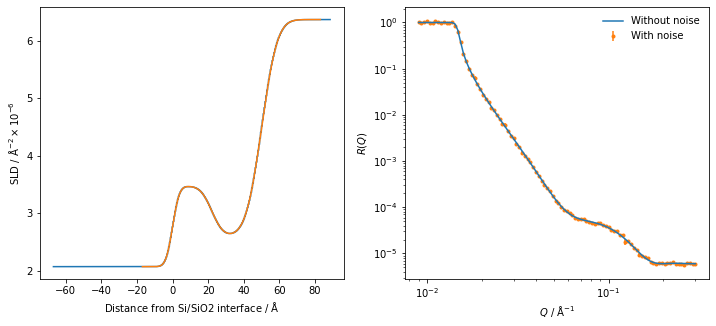

In [18]:
# lets see the SLD profile which created the simulated reflectivity & the reflectivity with added noise.

%matplotlib inline

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(VFP_model.structure.sld_profile(max_delta_z=0.1)[0]-(50+(4*3)), 
           VFP_model.structure.sld_profile(max_delta_z=0.1)[1])
ax[0].plot(*d2o_struct_normal.sld_profile())
ax[0].set_xlabel(r'Distance from Si/SiO2 interface / $\mathrm{\AA}$')
ax[0].set_ylabel(r'$\mathrm{SLD}$ / $\mathrm{\AA{}}^{-2} \times 10^{-6}$')


Q = np.geomspace(9E-3, 3E-1, 100)
ax[1].plot(Q, VFP_model.model(x=Q), label='Without noise', zorder=5)
ax[1].errorbar(x=Q, y=R_rand, yerr=np.absolute(noise), linestyle='none', marker='.', label='With noise')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_ylabel(r'$R\left(Q\right)$')
ax[1].set_xlabel(r'$Q$ / $\mathrm{\AA{}}^{-1}$')
ax[1].legend(frameon=False)
plt.show()

### Now we have our noisy data, lets fit it

In [19]:
#package up the noisy reflectivity
Data = np.vstack([Q, R_rand, np.abs(noise)])

In [20]:
Data_rfnx = ReflectDataset(Data)

In [21]:
#parameters to fit

SiO2_thick = Parameter(20, name='SiO2_thick', vary=True, bounds=(10, 30))
SiO2_rough = Parameter(1, name='SiO2_rough', vary=True, bounds=(1, 10))

Surf_thick = Parameter(10, name='Surf_thick', vary=True, bounds=(10, 40))
Surf_rough = Parameter(1, name='Surf_rough', vary=True, bounds=(1, 10))
Surf_vf = Parameter(0, name='Surf_vf', vary=True, bounds=(0, 1))

Surf_D2O_R = Parameter(1, name='Surf_D2O_R', vary=True, bounds=(1, 10))

In [22]:
### list up the thicknesses, roughnesses and slds to send to the vfp.

list_of_thickness_fit = (0, SiO2_thick, Surf_thick) #first must be zero for Si thickness.
list_of_roughness_fit = (SiO2_rough, Surf_rough, Surf_D2O_R)

In [23]:
"""
The nSLDs are ordered as the following:
Si, SiO2, Surfactant, D2O
"""

#these values can come from the layers defined above, the SLD objects above or some function of them.
nuclear_SLDs_fit = np.array([Si.real, SiO2_lay.sld.real, Surf_lay.sld.real*(1-Surf_vf)+D2O_lay.sld.real*Surf_vf, D2O_lay.sld.real])

#won't bother modelling any imaginary SLDs, but do need to declare them.
nuclear_iSLDs_fit = np.array([0, 0, 0, 0])

#similar with magnetic SLDs.
magnetic_SLDs_fit = np.array([0, 0, 0, 0])

In [24]:
# we need to put the parameters defined above into a tuple to pass to the objective(s).
auxiliary_parameters = (SiO2_thick, SiO2_rough, Surf_thick, Surf_rough, Surf_vf, Surf_D2O_R)

In [25]:
# create the extent parameter that describes how long the volume fraction profile is.

VFP_tot_fit = Parameter(name='VFP_tot_fit', constraint=50+(4 * SiO2_rough)+SiO2_thick+Surf_thick+5+(4 * Surf_D2O_R))

In [26]:
# now define the VFP
d2o_vfp_fit = VFP(extent=VFP_tot_fit, 
              nSLDs=nuclear_SLDs_fit, 
              niSLDs=nuclear_iSLDs_fit, 
              mSLDs=magnetic_SLDs_fit, 
              thicknesses=list_of_thickness_fit,
              roughnesses=list_of_roughness_fit, 
              contrast='D2O')

In [27]:
#wrap the vfp between the fronting and backing SLDs (not layers!)
d2o_struct_fit = Si | d2o_vfp_fit | D2O

In [28]:
intensity_p = Parameter(1, name='Intensity', vary=True, bounds=(0.8, 1.2))
bkg_p = Parameter(1e-6, name='bkg', vary=True, bounds=(1e-7, 1e-4))

In [29]:
VFP_model_fit = ReflectModel(d2o_struct_fit, scale=intensity_p, bkg=bkg_p, dq=3*2.355)

In [30]:
#remember to pass the auxiliary_parameters tuple to the objective!

VFP_obj_fit = Objective(VFP_model_fit, Data_rfnx, auxiliary_params=auxiliary_parameters)

glob_obj = GlobalObjective([VFP_obj_fit])

In [31]:
#We'll use dynesty to explore the combined prior & likelihood space

if __name__ == '__main__':
    sys.path.append(os.getcwd())
    from schwimmbad import MultiPool
    with MultiPool() as p:
        nested_sampler = dynesty.NestedSampler(glob_obj.logl, glob_obj.prior_transform, ndim=len(glob_obj.varying_parameters()), nlive=500, pool=p)
        nested_sampler.run_nested(dlogz=0.509, print_progress=True)
        p.close()
    res = nested_sampler.results
    print(res.logz[-1], res.logzerr[-1])
    print('Keys:', res.keys(),'\n')  # print accessible keys
    res.summary()  # print a summary

17943it [6:34:27,  1.32s/it, +500 | bound: 8938 | nc: 1 | ncall: 7805276 | eff(%):  0.236 | loglstar:   -inf < 961.592 <    inf | logz: 926.363 +/-  0.267 | dlogz:  0.001 >  0.509]


926.3625270206493 0.44512586181907343
Keys: ['nlive', 'niter', 'ncall', 'eff', 'samples', 'samples_id', 'samples_it', 'samples_u', 'logwt', 'logl', 'logvol', 'logz', 'logzerr', 'information', 'bound', 'bound_iter', 'samples_bound', 'scale'] 

Summary
nlive: 500
niter: 17943
ncall: 7804776
eff(%):  0.236
logz: 926.363 +/-  0.445


In [33]:
import pickle
### lets save the GO and NS results

with open('VFP_GO.pkl', 'wb+') as f:
    pickle.dump(glob_obj, f)

with open('VFP_NS.pkl', 'wb+') as f:
    pickle.dump(res, f)

In [34]:
### now lets open these results & analyse from there.

with open("VFP_GO.pkl","rb") as f:
	GO = pickle.load(f)
    
with open("VFP_NS.pkl","rb") as f:
	res_load = pickle.load(f)

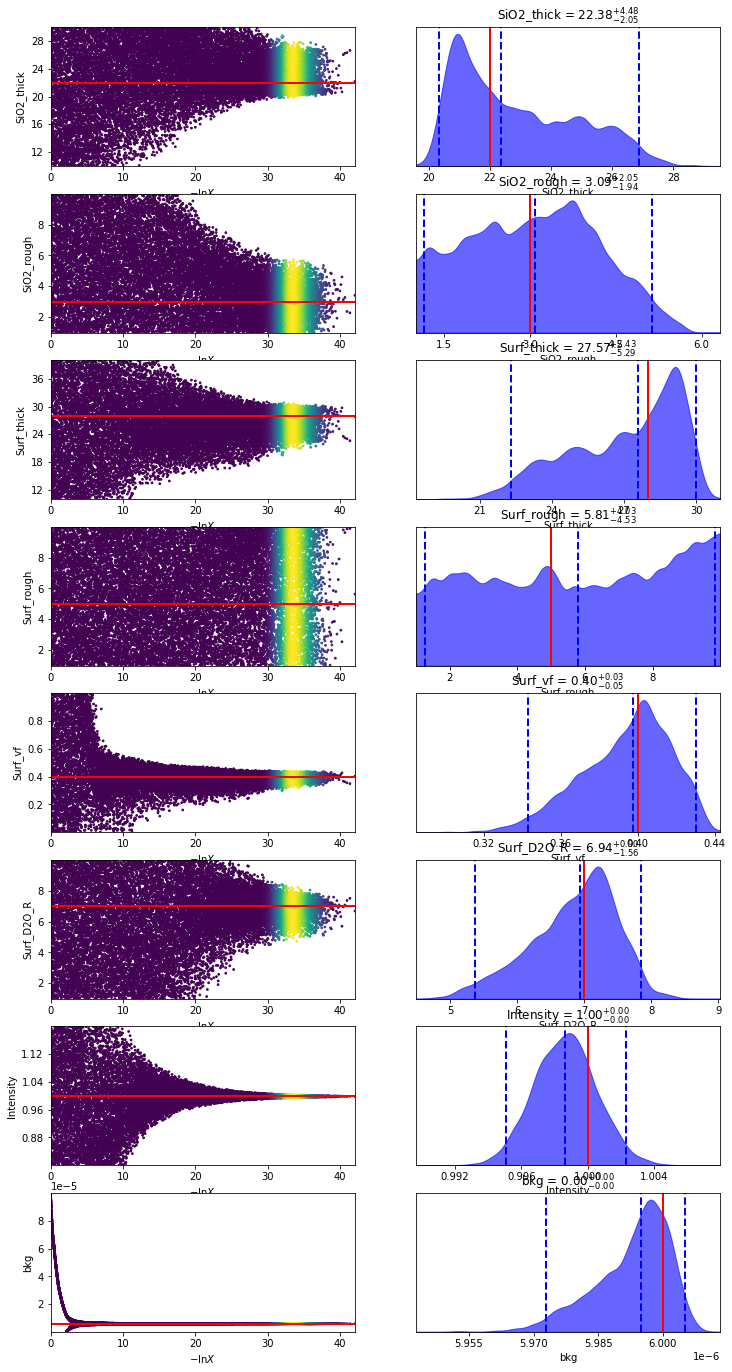

In [35]:
#take a look at the figure below
#The left hand side shows the evolution of the "dead" point (the point with the lowest likelihood) 
#while the right side shows the 1D posteriors (right), calculated from the combination of weights and dead points over the run.
#red line shows the true value of the parameter.
#coloured band in the dead points shows where the bulk of the posterior lies.

#notice the dead points for the bkg parameter are not uniformly spread at the start.
#this is because bkgs ~ 1e-4 & 1e-5 will significantly affect the likelihood (give you a very poor fit), 
#and so there is more of a noticable trend of the higher bkgs to be removed at very beginning.
#better prior choice would avoid having to sample these points that are clearly inappropriate, and speed up the sampling.

from dynesty import plotting as dyplot

labelz = GO.varying_parameters().names()
fig, axes = dyplot.traceplot(res_load, show_titles=True, trace_cmap='viridis', labels=labelz, truths=[22, 3, 28, 5, 0.4, 7, 1, 6e-6])
plt.show()

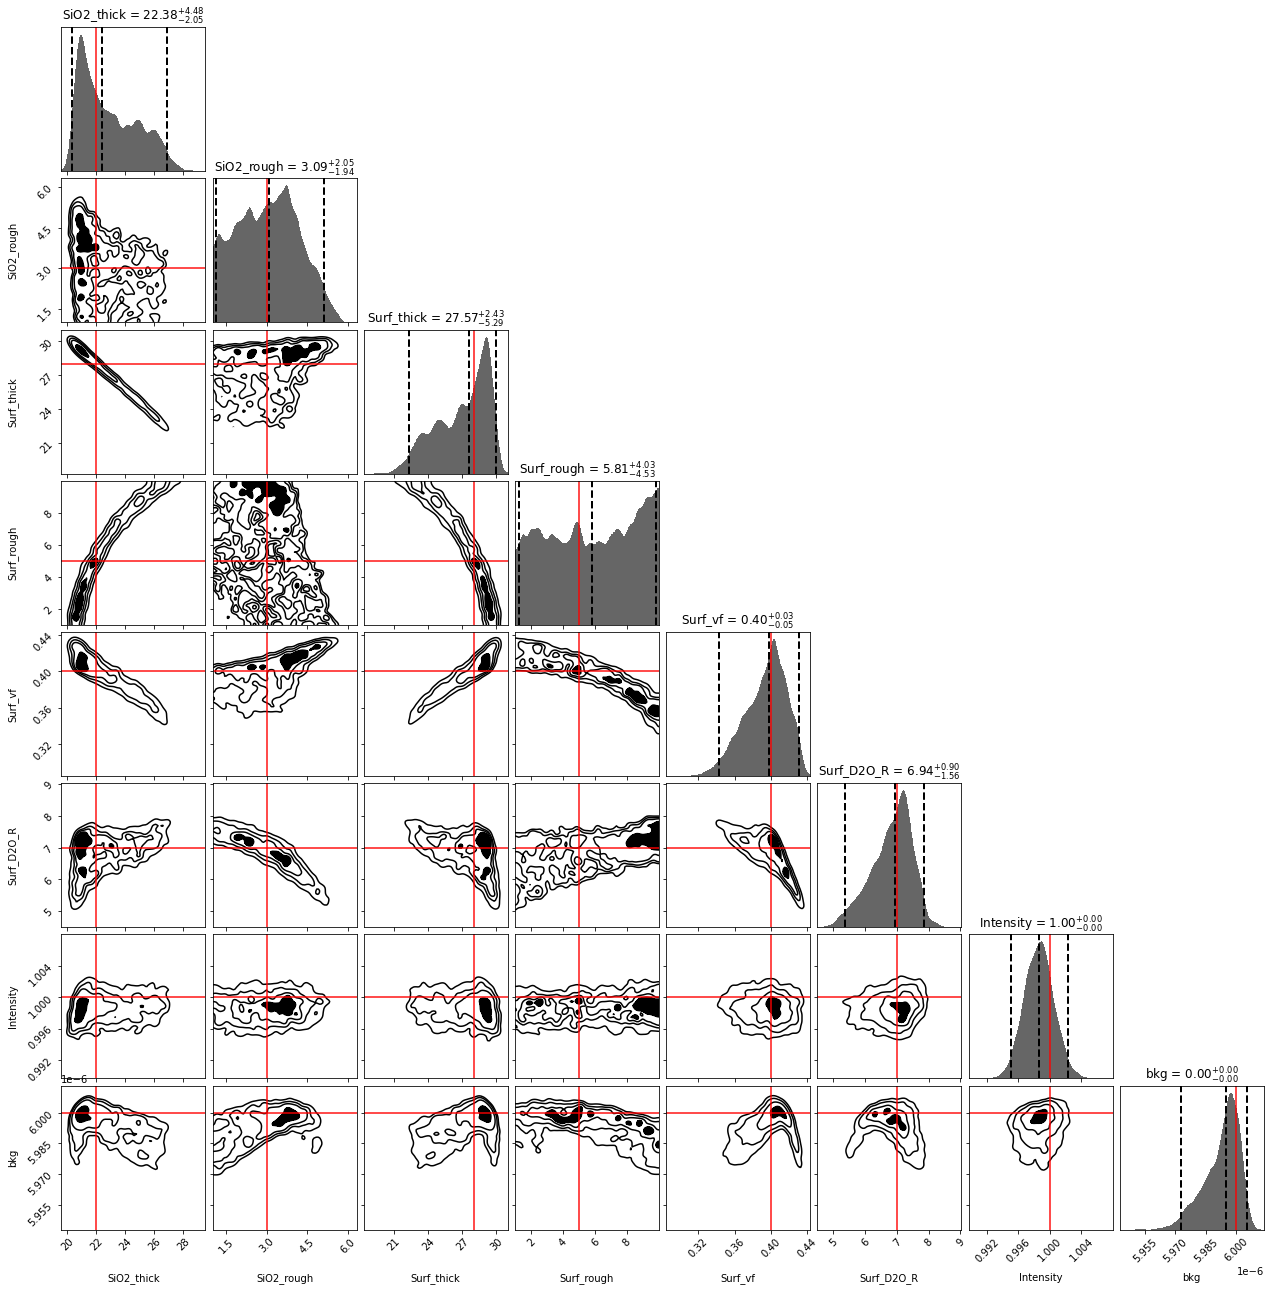

In [36]:
#Corner plot to show the posterior is complex & correlated.
#unsuprising, we only have one contrast.

fig, axes = dyplot.cornerplot(res_load, show_titles=True, labels=labelz, truths=[22, 3, 28, 5, 0.4, 7, 1, 6e-6])
plt.show()

SiO2_thick
    Median: 2.2383E+01
    Lower: 2.0335E+01
    Upper: 2.6864E+01
    Minus: 2.0472E+00
    Plus: 4.4816E+00
SiO2_rough
    Median: 3.0876E+00
    Lower: 1.1475E+00
    Upper: 5.1336E+00
    Minus: 1.9401E+00
    Plus: 2.0460E+00
Surf_thick
    Median: 2.7574E+01
    Lower: 2.2279E+01
    Upper: 3.0005E+01
    Minus: 5.2943E+00
    Plus: 2.4314E+00
Surf_rough
    Median: 5.8092E+00
    Lower: 1.2839E+00
    Upper: 9.8440E+00
    Minus: 4.5253E+00
    Plus: 4.0349E+00
Surf_vf
    Median: 3.9752E-01
    Lower: 3.4310E-01
    Upper: 4.3027E-01
    Minus: 5.4417E-02
    Plus: 3.2754E-02
Surf_D2O_R
    Median: 6.9382E+00
    Lower: 5.3771E+00
    Upper: 7.8419E+00
    Minus: 1.5612E+00
    Plus: 9.0368E-01
Intensity
    Median: 9.9864E-01
    Lower: 9.9511E-01
    Upper: 1.0023E+00
    Minus: 3.5328E-03
    Plus: 3.6521E-03
bkg
    Median: 5.9949E-06
    Lower: 5.9728E-06
    Upper: 6.0052E-06
    Minus: 2.2090E-08
    Plus: 1.0233E-08


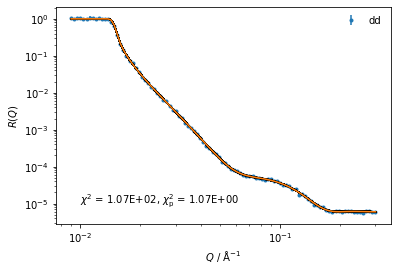

In [37]:
#lets take a look at the fit.

from dynesty import utils as dyfunc
from functools import reduce

samples = res_load.samples  # samples explored by nested sampling.
weights = np.exp(res_load.logwt - res_load.logz[-1])  # normalized weights. These glob_obj from low to high.

# Compute 2.5%-97.5% quantiles.
quantiles = [dyfunc.quantile(samps, [0.025, 0.5, 0.975], weights=weights)
             for samps in samples.T]

#lets print out the posterior found by NS.
for i, j in enumerate(quantiles):
    print(f"""{labelz[i]}
    Median: {j[1]:.4E}
    Lower: {j[0]:.4E}
    Upper: {j[2]:.4E}
    Minus: {j[1]-j[0]:.4E}
    Plus: {j[2]-j[1]:.4E}""")

#function to return the posterior of the samples.
def get_posterior(quantiles, samples, sample_len=300):
    """
    This function finds the samples from the nested sampling that lie within the 95 % CI for all parameters.
    First, the indexes of the parameter values between the individual 95 % CI are found.
    Then the indexes where all parameter values fall within the overall posterior.
    The full posterior sample is then returned. Finally, we take a sub-sample of the posterior.
    """
    indiv_index = []
    for i, j in enumerate(samples.T): #samples.T is (i x n) where i is the number of parameters & n is number of samples.
        indexes = np.where((j >= quantiles[i][0]) & (j <= quantiles[i][2]))[0] # return just the array.
        indiv_index.append(indexes) # a list of indexes of different sizes.
    
    #now find those samples that all within the posterior.
    intersect_tuple = tuple(i for i in indiv_index) # make tuple out of list of indexes.
    posterior_indexes = reduce(np.intersect1d, intersect_tuple) # now we have array of indicies of samples that are all within posterior.
    full_posterior = samples[posterior_indexes] # full posterior.
    
    if sample_len > len(posterior_indexes):
        sample_len = len(posterior_indexes)
        
    random_number = np.random.choice(posterior_indexes, size=sample_len, replace=False)
    sampled_posterior = samples[random_number]
    return sampled_posterior

#return 300 of the posterior samples.
posterior_samples = get_posterior(quantiles, samples, 300)

#set the varying_parameters stored in glob_obj to the median values found in quantiles.
for i, j in enumerate(labelz):
    if j == GO.varying_parameters()[i].name:
        GO.varying_parameters()[i].value = quantiles[i][1]

#lets plot the reflectivity, sld profiles and volume fraction profiles.
#first reflectivity:

saved_params = np.array(GO.parameters) #save the median parameter values in the global objective.

chi2 = GO.chisqr()
chi2red = chi2/(GO.npoints)

fig, ax = plt.subplots()
for i in posterior_samples: #plot the posterior
    GO.varying_parameters().pvals = i #change the values of the varying parameters to the posterior samples.
    ax.plot(GO.objectives[0].data.x, GO.objectives[0].generative(), color='k', alpha=0.05, linewidth=1.5) #then plot the dummy reflectivity
#plot the median reflectivity
GO.setp(saved_params)
ax.plot(GO.objectives[0].data.x, GO.objectives[0].generative(), color='tab:orange', zorder=2, linewidth=1.5)
#plot the data stored in the original objective.
ax.errorbar(GO.objectives[0].data.x, GO.objectives[0].data.y, yerr=GO.objectives[0].data.y_err, linestyle='None', marker='.', color='tab:blue', zorder=1, label='dd')
#formatting.
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel(r'$R\left(Q\right)$')
ax.set_xlabel(r'$Q$ / $\mathrm{\AA}^{-1}$')
ax.text(1E-2, 1E-5, f'$\chi^{2}$ = {chi2:.2E},' + r' $\chi^{2}_{\mathrm{p}}$ = ' + f'{chi2red:.2E}')
ax.legend(frameon=False)
plt.show()

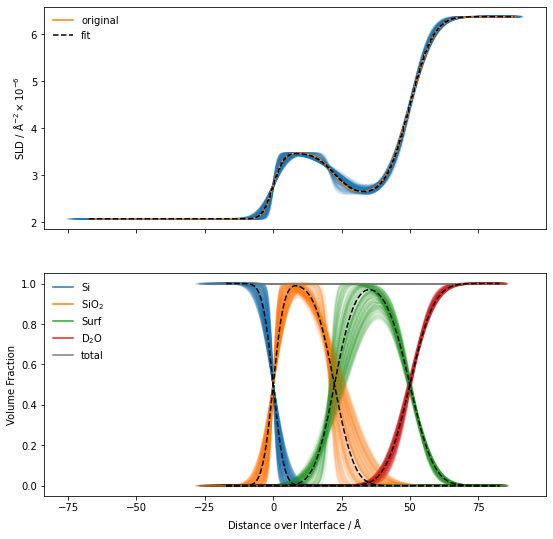

In [42]:
#now lets have a look at the SLD profile & the volume fraction profile.

fig2, ax2 = plt.subplots(2, figsize=(9, 9), sharex=True)

for i in posterior_samples:
    GO.varying_parameters().pvals = i
    ax2[0].plot(
                GO.objectives[0].model.structure.sld_profile(max_delta_z=0.1)[0]-(50 + 4 * GO.varying_parameters()[1]), 
                GO.objectives[0].model.structure.sld_profile(max_delta_z=0.1)[1], 
                color='tab:blue', alpha=0.05
                )
    ax2[1].plot(
                GO.objectives[0].model.structure.components[1].get_x_and_y_scatter()[0],
                GO.objectives[0].model.structure.components[1].vfs_for_display()[0][0].T,
                color='tab:blue', alpha=0.05
                )
    ax2[1].plot(
                GO.objectives[0].model.structure.components[1].get_x_and_y_scatter()[0],
                GO.objectives[0].model.structure.components[1].vfs_for_display()[0][1].T,
                color='tab:orange', alpha=0.05
                )
    ax2[1].plot(
                GO.objectives[0].model.structure.components[1].get_x_and_y_scatter()[0],
                GO.objectives[0].model.structure.components[1].vfs_for_display()[0][2].T,
                color='tab:green', alpha=0.05
                )
    ax2[1].plot(
                GO.objectives[0].model.structure.components[1].get_x_and_y_scatter()[0],
                GO.objectives[0].model.structure.components[1].vfs_for_display()[0][3].T,
                color='tab:red', alpha=0.05
                )
    ax2[1].plot(
                GO.objectives[0].model.structure.components[1].get_x_and_y_scatter()[0],
                np.sum(GO.objectives[0].model.structure.components[1].vfs_for_display()[0].T, axis=1),
                color='tab:grey', alpha=0.05)
#plot original SLD profile before noise.
ax2[0].plot(VFP_model.structure.sld_profile(max_delta_z=0.1)[0]-(50+4*3), 
           VFP_model.structure.sld_profile(max_delta_z=0.1)[1], 
           label='original',
           color='tab:orange')
#recover median values
GO.setp(saved_params)
#now plot median SLD and vf profiles.
ax2[0].plot(
            GO.objectives[0].model.structure.sld_profile(max_delta_z=0.1)[0]-(50 + 4 * GO.varying_parameters()[1]), 
            GO.objectives[0].model.structure.sld_profile(max_delta_z=0.1)[1], 
            color='k',
            linestyle='--',
            label='fit'
            )
ax2[1].plot(
            GO.objectives[0].model.structure.components[1].get_x_and_y_scatter()[0],
            GO.objectives[0].model.structure.components[1].vfs_for_display()[0][0].T,
            color='k', linestyle='--'
            )
ax2[1].plot(
            GO.objectives[0].model.structure.components[1].get_x_and_y_scatter()[0],
            GO.objectives[0].model.structure.components[1].vfs_for_display()[0][1].T,
            color='k', linestyle='--'
            )
ax2[1].plot(
            GO.objectives[0].model.structure.components[1].get_x_and_y_scatter()[0],
            GO.objectives[0].model.structure.components[1].vfs_for_display()[0][2].T,
            color='k', linestyle='--'
            )
ax2[1].plot(
            GO.objectives[0].model.structure.components[1].get_x_and_y_scatter()[0],
            GO.objectives[0].model.structure.components[1].vfs_for_display()[0][3].T,
            color='k', linestyle='--'
            )
#formatting

import matplotlib.lines as mlines

vf_Si = mlines.Line2D([], [], color='tab:blue',  label=r'Si')
vf_SiO2 = mlines.Line2D([], [], color='tab:orange',  label=r'SiO$_{2}$')
vf_Surf = mlines.Line2D([], [], color='tab:green',  label=r'Surf')
vf_D2O = mlines.Line2D([], [], color='tab:red',  label=r'D$_{2}$O')
vf_total = mlines.Line2D([], [], color='tab:grey', label=r'total')

ax2[0].set_ylabel(r'$\mathrm{SLD}$ / $\mathrm{\AA}^{-2} \times 10^{-6}$')
ax2[0].legend(frameon=False)

ax2[1].set_xlabel(r'Distance over Interface / $\mathrm{\AA}$')
ax2[1].set_ylabel(r'Volume Fraction')
ax2[1].legend(handles=[vf_Si, vf_SiO2, vf_Surf, vf_D2O, vf_total], frameon=False)
plt.show()